In [183]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from IPython import display
%matplotlib inline

In [184]:
from scipy.spatial.distance import cosine


full_french = np.zeros((len(french_vecs.vocab.keys()), 300))
vocab = []
i = 0
for w in french_vecs.vocab.keys():
    full_french[i] = french_vecs[w]
    vocab.append(w)
    i += 1
    
def compute_dist(word, model):
    model.eval()
    dists = []
    for w in vocab:
        dists.append(cosine(model(torch.from_numpy(eng_vecs[word])).data.numpy(), 
               french_vecs[w]))
    return dists


def show_nearest_word(word, model):
    return vocab[np.array(compute_dist(word, model)).argmin()]

In [185]:
# download vectors from fasttext 
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors 

def plot_tsne(model):
    "Visualizing the word vectors"
    labels = []
    tokens = []

    for word in model.vocab.keys():
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=4, n_components=2,
                      n_iter=2500, random_state=2)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(5, 5)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
french_vecs = KeyedVectors.load_word2vec_format('data/french_vecs.txt')
eng_vecs = KeyedVectors.load_word2vec_format('data/en_vecs.txt')

In [194]:
from __future__ import print_function
from itertools import count

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


class Mapper(nn.Module):
    def __init__(self, dim=300):
        super(Mapper, self).__init__()
        self.projection = nn.Linear(dim, dim)
        
    def forward(self, x):
        return self.projection(x)
    


def train(epochs):
    torch.manual_seed(123)
    model = Mapper().to('cpu')

    loss_fn = nn.MSELoss(size_average=False)

    optimizer = optim.SGD(model.parameters(), lr=0.01)

    enfr_dict = {'king': 'roi',
            'queen': 'reine',
            'london': 'londres',
            'meets': 'rencontre',
            'project': 'projet'}
    epo = []
    elo = []
    x = [1, 5, 1, 5, 1, 5, 1, 5, 1, 5]
    y = [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
    
    for epoch in range(epochs):
        lo = []
        labels = []
        plt.clf()
        plt.cla()
        plt.close()
        plt.figure(figsize=(7, 7))

        for en, fr in enfr_dict.items():
            model.train()
            data, target = (torch.from_numpy(eng_vecs[en]).to('cpu'), 
                            torch.from_numpy(french_vecs[fr]).to('cpu'))
            optimizer.zero_grad()
            output = model(data)
            labels.append(en)
            labels.append(vocab[np.array(compute_dist(en, model=model)).argmin()])
            loss = loss_fn(output, target)
            loss.backward() 
            optimizer.step() 
            lo.append(loss.item())


        elo.append((np.average(lo)))
        epo.append(epoch)
        
        
        
        plt.subplot(1,2,1)
        plt.plot(epo, elo)
        plt.xlabel('Epoch')
        plt.ylabel('Distance')
        
        
        plt.subplot(1,2,2)
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            plt.annotate(labels[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
        plt.axis('off')    
        # plt.tight_layout()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        # display.clear_output()
        time.sleep(1)
        display.clear_output(wait=True)
    print('Initial Objective = %5f' % elo[0])
    print('Final Objective = %10f' % np.average(lo))
    return model
    

    




In [187]:

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

            
lang1 = Lang('fr')
lang2 = Lang('en')

In [188]:
pairs = [['tu es probablement trop jeune pour le comprendre .',
  'you re probably too young to understand this .'],
 ['je pense apprendre le coreen le semestre prochain .',
  'i m thinking of learning korean next semester .'],
 ['elle trouve toujours a redire aux autres .',
  'she is always finding fault with other people .'],
 ['elle est tres receptive a la suggestion hypnotique .',
  'she s very susceptible to hypnotic suggestion .'],
 ['nous enquetons sur le meurtre de tom jackson .',
  'we re investigating the murder of tom jackson .'],
 ['elle est non seulement belle mais aussi intelligente .',
  'she is not only beautiful but also intelligent .'],
 ['il entreprend des experiences dans son laboratoire .',
  'he is carrying out experiments in his laboratory .'],
 ['j ai quelques difficultes a compiler ce programme .',
  'i m having some problems compiling this software .'],
 ['ils collectent des dons pour l eglise .',
  'they are collecting contributions for the church .'],
 ['il est un des candidats aux presidentielles americaines .',
  'he is one of the american presidential candidates .']]


for pair in pairs: 
    lang1.addSentence(pair[0])
    lang2.addSentence(pair[1])
    
MAX_LENGTH = 10

In [189]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.rnn = nn.RNN(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# basic pre-processing

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang1, pair[0])
    target_tensor = tensorFromSentence(lang2, pair[1])
    return (input_tensor, target_tensor)


In [190]:
def trainED(input_tensor, target_tensor, encoder, 
          decoder, encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, 
                                  encoder.hidden_size, 
                                  device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, 
                                                 decoder_hidden)
        
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di] 

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

    
def trainAED(input_tensor, target_tensor, encoder, 
          decoder, encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, 
                                  encoder.hidden_size, 
                                  device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                 decoder_hidden, 
                                                encoder_outputs)
        
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di] 

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



def trainIters(encoder, decoder, learning_rate=0.01, epochs=10):
    torch.manual_seed(123)
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    encoder.train()
    decoder.train()
    
    criterion = nn.NLLLoss()
    lavg = []
    eps = []
    for epoch in range(epochs):
        training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(len(pairs))]
        loss_total = 0
        
        plt.clf()
        plt.cla()
        plt.close()
        plt.figure(figsize=(5, 5))
        for iter in range(len(pairs)):
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = trainED(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
            loss_total += loss
        lavg.append(loss_total / len(pairs))
        eps.append(epoch+1)

        plt.plot(eps, lavg)
        
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        # display.clear_output()
        time.sleep(1)
        display.clear_output(wait=True)        

        
def trainItersAED(encoder, decoder, learning_rate=0.01, epochs=10):
    torch.manual_seed(123)
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    encoder.train()
    decoder.train()
    
    criterion = nn.NLLLoss()
    lavg = []
    eps = []
    for epoch in range(epochs):
        training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(len(pairs))]
        loss_total = 0
        
        plt.clf()
        plt.cla()
        plt.close()
        plt.figure(figsize=(5, 5))
        for iter in range(len(pairs)):
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = trainAED(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
            loss_total += loss
        lavg.append(loss_total / len(pairs))
        eps.append(epoch+1)

        plt.plot(eps, lavg)
        
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        # display.clear_output()
        time.sleep(1)
        display.clear_output(wait=True)        


In [191]:
def sampleED(encoder, decoder, sentence, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(lang1, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang2.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

    
def sampleAED(encoder, decoder, sentence, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval() 
    with torch.no_grad():
        input_tensor = tensorFromSentence(lang1, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang2.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


In [192]:
def randomED(encoder, decoder, n=1):
    for i in range(n):
        pair = random.choice(pairs)
        print('French     : ', pair[0])
        print('Reference: ', pair[1])
        output_words= sampleED(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Translation  : ', output_sentence)
        print('')

        
def randomAED(encoder, decoder, n=1):
    for i in range(n):
        pair = random.choice(pairs)
        print('French     : ', pair[0])
        print('Reference: ', pair[1])
        output_words, attentions= sampleAED(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Translation  : ', output_sentence)
        print('')

        
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = sampleAED(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)





<center>
<h2>Neural Machine Translation</h2>
<p style="text-align:center">
Natural Language Processing<br>
(COM4513/6513)<br>
<br>
<a href="http://pranava.space">Pranava Madhyastha</a><br>
p.madhyastha@sheffield.ac.uk<br>
<small>Department of Computer Science<br>
University of Sheffield
</small>
</p>
</center>

## If we don't know how to perform a task, it's unlikely that an ML algorithm will find it out for us (Lecture 1)

### Recap 1

Distributed word representations/Word Vectors (Lecture 12):


### Recap 1

Distributed word representations/Word Vectors (Lecture 12):

- Based on word-context matrix
- Skip-gram (Mikolov et al. 2013) 
- Neural Language modeling (Lab 9) 

<center>
<img src="images/skipgram.png" style="width:500px; background:none; border:none; box-shadow:none;">
</center>

## Visualizing Distributed Representations


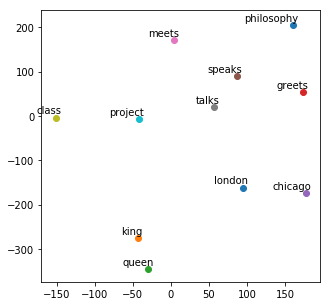

In [119]:
plot_tsne(eng_vecs)

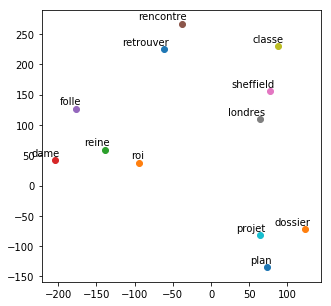

In [120]:
plot_tsne(french_vecs)

## Can We Map the Two Distributional Spaces? 

### Problem setup

- Training signal can be **word to word** dictionary

\begin{align}
D_{train} & = \{(\mathbf{en}_1,\mathbf{fr}_1) \cdots (\mathbf{en}_M,\mathbf{fr}_M)\} \\
\mathbf{en}_m & = \phi(king)\\
\mathbf{fr}_m & = \phi(roi)
\end{align}




### What do we need? 


### What do we need? 

## A mapping function that maps from English domain to the French domain

- A function that transforms initial English word-vector to be as close as the corresponding French word-vector

\begin{equation}
f(\phi(king))\mathop{\sim}\phi(roi)
\end{equation}



## A mapping function that maps from English domain to the French domain

- A function that transforms initial English word-vector to be as close as the corresponding French word-vector

\begin{equation}
f(\phi(king))\mathop{\sim}\phi(roi)
\end{equation}

- can we learn $f$ as a linear transformation? 

\begin{equation}
(\phi(king){\cdot}W)\mathop{\sim}\phi(roi)
\end{equation}


### What can we have as our training objective? 

\begin{equation}
\mathop{\min} distance\big({\phi(king)}{\cdot}\mathbf{W} - \phi(roi)\big)
\end{equation}



### Let us use a very small dictionary for training



| eng     | french    |
| --------|-----------|
| king    | roi       |
| queen   | reine     |
| london  | londres   | 
| meets   | rencontre |
| project | projet    |


Initial Objective = 5.820566
Final Objective =   0.052495


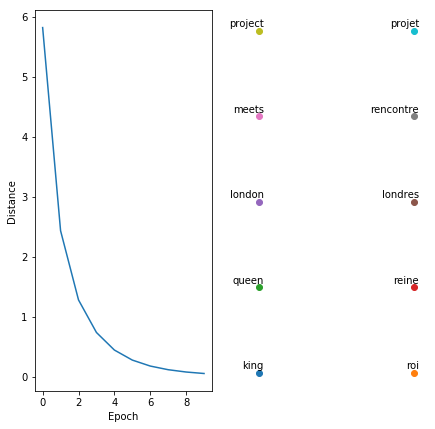

In [213]:
model = train(10)

# UNSEEN Training Words? 

In [215]:
# greets, meets, speaks

show_nearest_word('greets', model=model)

'rencontre'

### Recap 2: 

Recurrent Neural Networks (Lecture 14):

## Recap 2: 

### Recurrent Neural Networks (Lecture 14):
<center>
<a href="http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/"><img src="images/rnn.jpg" style="width:800px; background:none; border:none; box-shadow:none;" /></a>
</center>

## RNNs 

### Can be used to build Language Models

### RNNs can model Sentences!

### RNNs also Generate Sentences! 

### Recap 3: 

#### RNNs as Conditional Language Models (Lecture 14)
<center>
<a href="http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/"><img src="images/rnn_mt.png" style="width:800px; background:none; border:none; box-shadow:none;" /></a>
</center>

### Problem setup

- Sentences are sequences of words 
- Training signal is **sentence to sentence** parallel corpus

\begin{align}
D_{train} & = \{(\mathbf{en}_1,\mathbf{fr}_1) \cdots (\mathbf{en}_M,\mathbf{fr}_M)\} \\
\mathbf{en}_m & = e_1 \cdots e_r\\
\mathbf{fr}_m & = f_1 \cdots f_k
\end{align}

- Sequences can be of any lengths (r, k)  

## Encode the Source 

\begin{equation}
\mathbf{h_t} = f_{encoder}(\mathbf{h_{t-1}}, \mathbf{V_{fr}}^{\top}\mathbf{f_t})
\end{equation}


- Final hidden state contains history of all source tokens 
- Final hidden state provides the information of the source sentence 
- Let us call the final hidden state the 'context' **c** 

## Decode the Target

\begin{equation}
\mathbf{o_t} = f_{decoder}\big(\mathbf{o_{t-1}}, [\mathbf{V_{en}}^{\top}\mathbf{f_t}; \mathbf{c}]\big)
\end{equation}

## Obtain the probability over the target vocabulary
\begin{equation}
p(en_t{\mid}en_{t-1}, fr_m) \propto \exp(\mathbf{v_{en}}^{\top}\mathbf{o_t}) 
\end{equation}

|  French                                              |              English                            |
|--------------------------------------------------------------------------------------------------------|
| tu es probablement trop jeune pour le comprendre .   | you re probably too young to understand this .  |
| je pense apprendre le coreen le semestre prochain .  | i m thinking of learning korean next semester . |
| elle trouve toujours a redire aux autres .           | she is always finding fault with other people . |

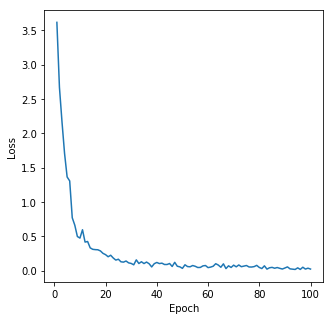

In [220]:
hidden_size = 256
encoder = EncoderRNN(lang1.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, lang2.n_words).to(device)

trainIters(encoder, decoder, epochs=100)


In [221]:
randomED(encoder, decoder, n=5)

French     :  il entreprend des experiences dans son laboratoire .
Reference:  he is carrying out experiments in his laboratory .
Translation  :  he is carrying out experiments in his laboratory . <EOS>

French     :  elle trouve toujours a redire aux autres .
Reference:  she is always finding fault with other people .
Translation  :  she is always finding fault with other people . <EOS>

French     :  tu es probablement trop jeune pour le comprendre .
Reference:  you re probably too young to understand this .
Translation  :  you re probably too young to understand this . <EOS>

French     :  je pense apprendre le coreen le semestre prochain .
Reference:  i m thinking of learning korean next semester .
Translation  :  i m thinking of learning korean next semester . <EOS>

French     :  elle est tres receptive a la suggestion hypnotique .
Reference:  she s very susceptible to hypnotic suggestion .
Translation  :  she s very susceptible to hypnotic suggestion . <EOS>



# Potential Problems?

- Whole source sentence is compressed into one single vector
- **The context vector is different from just a simple sentence vector** 
- Sometimes we need subtle contextual cues for translating smaller segments
- The simple model can still work, but the computational cost exponentially increases!

## Recall novelty in Phrase Based SMT

- Word or Phrasal Alignments between source and target languages



## Attention based NMT

<center>
<a href="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2017/07/20/sockeye_1.gif"><img src="images/anmt.png" style="width:800px; background:none; border:none; box-shadow:none;" /></a>
</center>

## Attention based NMT

* The idea originated independently of the alignment assumption
* In someways it converges to the alignment idea
* Key Concept: **Specialized Contexts**
* Focused contextual information for decoding at target time $\mathbf{o_t}$

## Modeling Attention

- Key Difference: Source Context **Set** instead of a Single Context vector

- Source Set = $\mathbf{h_m} = [\mathbf{h_1}, \cdots, \mathbf{h_m}]$

- Compute the score on the context set
\begin{equation}
s_{j,t} = f_{scorer}(\mathbf{o_{t-1}}, \mathbf{V_{eng}}^{\top}\mathbf{f_t}, \mathbf{h_j})
\end{equation}

## Obtain a Probabilistic Measure 

- Normalize or Softmax it

\begin{equation}
\alpha_{j,t} = \frac{\exp(s_{j,t})}{\sum_{j'=1}^{k}\exp(s_{j',t})}
\end{equation}

- The resultant context vector is: 
\begin{equation}
\mathbf{c_t} = \sum_{j=1}^{k}\alpha_{j,t}\mathbf{h_j}
\end{equation}

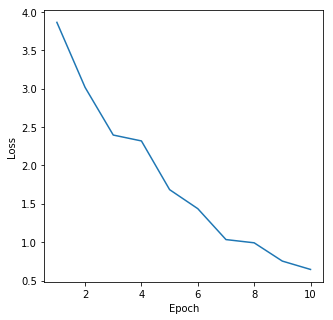

In [222]:
hidden_size = 256
encoder = EncoderRNN(lang1.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, lang2.n_words).to(device)

trainItersAED(encoder, decoder, epochs=10)

input = je pense apprendre le coreen le semestre prochain .
output = i m having some problems compiling this software . <EOS>


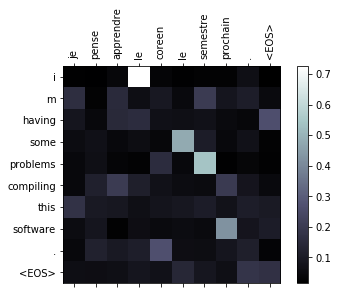

In [224]:
# evaluateAndShowAttention("tu es probablement trop jeune pour le comprendre .")

evaluateAndShowAttention("je pense apprendre le coreen le semestre prochain .")

# evaluateAndShowAttention("nous enquetons sur le meurtre de tom jackson .")


## Encoder-Decoder models have potentially many use cases!


#### Recap (Lecture 14):

<center>
<a href="http://kelvinxu.github.io/projects/capgen.html"><img src="images/capgen.png" style="width:800px; background:none; border:none; box-shadow:none;"/></a>
</center>

## Sadly, I am skipping a whole lot :-(

- Encoding strategies - bidirectional contexts
- Convolutional Neural Networks for NMT
- Parallelized attention only models
- Decoding Strategies - is argmax sufficient? 
- Beam Search 

## Sneak Peak Into the Imitation Learning / Meta Learning

- Can we teach models and make them learn from their mistakes? 

<center>
<img src="images/imitationFromRoss.png" style="width:800px; background:none; border:none; box-shadow:none;" /></a>
</center>

# Bibliography

- Cho's [lecture notes](http://arxiv.org/pdf/1511.07916v1.pdf) (he is one of the inventors!)
- [Guided Codebase](http://opennmt.net/)
